In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

import shap
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics

sys.path.append('../')
from pipelines import solution_1
import pipeline_config as cfg

# EXPERIMENT_DIR = 'YOUR/PATH/TO/EXPERIMETS'
EXPERIMENT_DIR = '/mnt/ml-team/minerva/avito/kuba/experiments'

neptune: Executing in Offline Mode.


# Solution 1

Local CV: **0.2278**
Public LB: **0.2351**

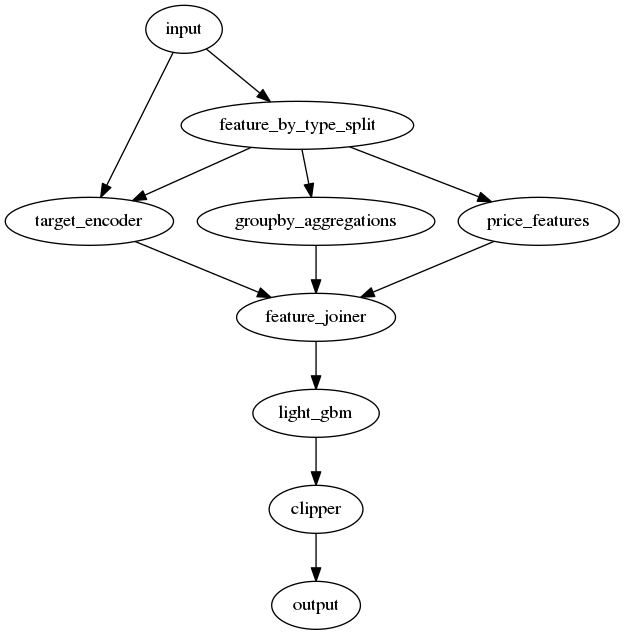

In [2]:
solution_1(cfg.SOLUTION_CONFIG, train_mode=False)

## Feature Extraction
* price features - for now just the price value
* target encoded features - likelihood encoding for categorical features
* groupby aggregations - features calculated based on aggregated categories

```python
    'groupby_aggregation': {'groupby_aggregations': [
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['user_id'], 'select': 'parent_category_name', 'agg': 'nunique'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['region'], 'select': 'parent_category_name', 'agg': 'count'},
        {'groupby': ['city'], 'select': 'parent_category_name', 'agg': 'count'},
    ]},
```

## Models
* lightgbm with the following parameters

```yaml
  lgbm_random_search_runs: 0
  lgbm__boosting_type: 'gbdt'
  lgbm__objective: regression
  lgbm__metric: RMSE
  lgbm__number_boosting_rounds: 300
  lgbm__early_stopping_rounds: 30
  lgbm__learning_rate: 0.05
  lgbm__num_leaves: 77
  lgbm__max_depth: 11
  lgbm__min_child_samples: 44
  lgbm__max_bin: 379
  lgbm__subsample: 0.82
  lgbm__subsample_freq: 2
  lgbm__colsample_bytree: 0.27
  lgbm__min_child_weight: 4
  lgbm__reg_lambda: 0.0
  lgbm__reg_alpha: 0.1
```

## Model exploration

In [3]:
model_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'transformers','light_gbm')
light_gbm_model = lgb.Booster(model_file=model_filepath)

### Feature Importance

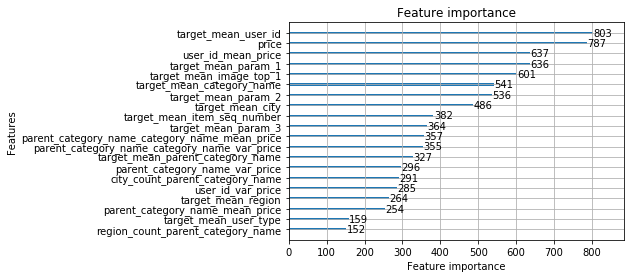

In [4]:
ax = lgb.plot_importance(light_gbm_model, max_num_features=20)
plt.show()

## Result Exploration

In [5]:
prediction_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'evaluation_predictions.csv')
evaluation_predictions =  pd.read_csv(prediction_filepath)
evaluation_predictions.sort_values('score', ascending=False, inplace=True)

In [6]:
evaluation_predictions.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,y_pred,score
300684,6f9064244726,cb6537262a06,Свердловская область,Екатеринбург,Услуги,Предложение услуг,"Красота, здоровье",NaN,NaN,Парикмахер на дому и с выездом на дом,"Дорогие девушки и женщины! Стилист, с опытом р...",NaN,763,2017-03-15,Company,d4953d3d17cf4d2437d748d0cda5c70d3a4c3053ca4e9d...,248.0,1.00000,0.110689,0.889311
300683,b0b51242ab46,4fad0ffde337,Челябинская область,Челябинск,Для дома и дачи,Бытовая техника,Для кухни,Холодильники и морозильные камеры,NaN,Холодильник stinol-123,"включается, работает, но не морозит. требуется...",1500.0,42,2017-03-18,Private,c323d4d569abf5884d5e77b577f872f0fcd9b58763c8e5...,1787.0,0.00000,0.878445,0.878445
300682,af6b052aa6f5,bafb59303191,Алтайский край,Барнаул,Для дома и дачи,Посуда и товары для кухни,Товары для кухни,NaN,NaN,Мясорубка,В таком состоянии.,100.0,814,2017-03-28,Company,b54459359524194eaf54e0d066b0efb8a0ee34748a5808...,1712.0,0.86521,0.000000,0.865210


# Shap

In [7]:
feature_extraction = solution_1(cfg.SOLUTION_CONFIG, train_mode=False).get_step('feature_joiner')

In [12]:
data = {'input': {'X': evaluation_predictions[cfg.FEATURE_COLUMNS],
                  'y': None,
                 },
            }

features = feature_extraction.transform(data)
features_df = features['features']

2018-05-13 12-49-26 steps >>> step feature_joiner loading output...


In [13]:
SAMPLE_SIZE=10000
shap.initjs() 
shap_values = shap.TreeExplainer(light_gbm_model).shap_values(features_df[:SAMPLE_SIZE])

In [15]:
import ipywidgets as ipy

@ipy.interact(i=ipy.IntSlider(min=0,max=SAMPLE_SIZE, value=0, step=1))
def plot(i):
    display(shap.force_plot(shap_values[i], features_df.iloc[i]))
    display(features_df[i:i+1])
    display(evaluation_predictions[i:i+1])

interactive(children=(IntSlider(value=0, description='i', max=10000), Output()), _dom_classes=('widget-interact',))